# Text categorization with BERT

This notebook aim to test the [transformer](https://pypi.org/project/transformers/) python package developed by [huggingface](https://github.com/huggingface) which gives access to pretrained BERT models. In order to test this package and model we will use the dataset [Sentiment extraction](https://www.kaggle.com/c/tweet-sentiment-extraction) available on kaggle. We will not focus on the NER task but simply use this labelised dataset for sentiment analysis. The tweets are seperated in three categories:
- Negative
- Neutrale
- Positive

I will personally run this notebook on a google colab in order to use the free GPUs, but you could run it on any other computer or VM. I would however recommend using GPU for training to avoid extensive training times.

#### Requierments:
- numpy==1.19.5
- pandas==1.1.5
- matplotlib==3.2.2
- torch==1.8.1+cu101
- transformers==4.5.1
- sklearn==0.0

### This cell need to be ran only if you are using google colab

In [ ]:
# from google.colab import drive
# drive.mount("/content/drive/", force_remount=True)
# import os
# os.chdir('drive/MyDrive/NLP/Sentiment_analysis/src')
# !pip install transformers

Mounted at /content/drive/


## Imports

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset, random_split

from transformers import get_linear_schedule_with_warmup
from transformers import AdamW, BertConfig, BertModel, BertTokenizer

from sklearn.metrics import f1_score, accuracy_score, confusion_matrix

## Environement setup

We look if cuda is available and if so we indicate to PyTorch to run on the GPU instead of the CPU.

In [ ]:
# select device
if torch.cuda.is_available():        
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

device

device(type='cuda')

## Data loading

In [ ]:
tweets = pd.read_csv("../data/sentiment_analysis.csv").loc[:,["text","sentiment"]].rename(index=str, columns={"sentiment": "target"}).dropna()
tweets

,text,target
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...",negative
...,...,...
27476,wish we could come see u on Denver husband l...,negative
27477,I`ve wondered about rake to. The client has ...,negative
27478,Yay good for both of you. Enjoy the break - y...,positive
27479,But it was worth it ****.,positive


### Check of the target balance

In [ ]:
tweets['target'].value_counts()

neutral     11117
positive     8582
negative     7781
Name: target, dtype: int64

## Data preprocessing
We look for duplicates in the data and remove them.

In [ ]:
dupli_sum = tweets.duplicated().sum()
if(dupli_sum > 0):
    print(dupli_sum, " duplicates found\nremoving...")
    tweets = tweets.loc[tweets.duplicated()==False, :]
else:
    print("no duplicates found")
tweets

no duplicates found


,text,target
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...",negative
...,...,...
27476,wish we could come see u on Denver husband l...,negative
27477,I`ve wondered about rake to. The client has ...,negative
27478,Yay good for both of you. Enjoy the break - y...,positive
27479,But it was worth it ****.,positive


### Seperate the features from the label

In [ ]:
def get_y(label):
  if label == "positive":
    return [1., 0., 0.]
  elif label == "neutral":
    return [0., 1., 0.]
  elif label == "negative":
    return [0., 0., 1.]

X_tweets = tweets["text"].values
y_tweets = np.array([get_y(l) for l in tweets["target"].values])

### Determination of the sequence length
As we will use batchs for the training we have to have all tweets of the same size. The tweets which are to long will be truncated, and the tweets too short will be padded. 

In [ ]:
# We load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# We compute the length of each tweet in the dataset
lens = []
for text in X_tweets:
    encoded_dict = tokenizer.encode_plus(text, add_special_tokens=True, return_tensors='pt')
    lens.append(encoded_dict['input_ids'].size()[1])

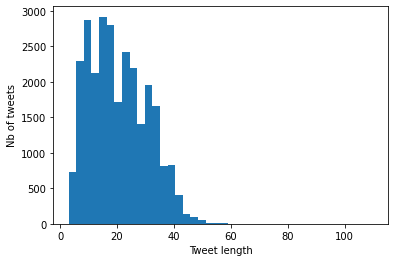

text length mean:  20.71353711790393
text length median:  20.0
text length standard deviation:  10.082886051513581
suitable sequence length:  40.87930922093109


In [ ]:
plt.hist(lens, bins=40)
plt.xlabel('Tweet length')
plt.ylabel('Nb of tweets')
plt.show()

print("text length mean: ", np.array(lens).mean())
print("text length median: ", np.median(lens))
print("text length standard deviation: ", np.array(lens).std())
print("suitable sequence length: ", np.array(lens).mean() + 2*np.array(lens).std())

In [ ]:
sequence_length = 41

## Tweets tockenization and tensor loading

Here we tockenize all the tweets with the BERT tockenizer and load them into PyTorch tensors. We also put all the tweets at the same size using padding and truncation based on the `sequence_length` computed earlier.

In [ ]:
X_tweets_tokens = []

for text in X_tweets:
    encoded_dict = tokenizer.encode_plus(text,
                                         add_special_tokens=True, # special tokens for BERT
                                         max_length=sequence_length,
                                         padding="max_length",
                                         return_tensors='pt', # pytorch tensor format
                                         truncation=True)
    X_tweets_tokens.append(encoded_dict['input_ids'])

# pytorch expects tensors
X_tweets_tokens = torch.cat(X_tweets_tokens, dim=0) # concat into one tensor
y_tweets = torch.tensor(y_tweets)

#### An example of loaded tweet:

In [ ]:
print('Original:\n', X_tweets[0])
print('Tokenization:\n', X_tweets_tokens[0])

Original:
  I`d have responded, if I were going
Tokenization:
 tensor([ 101, 1045, 1036, 1040, 2031, 5838, 1010, 2065, 1045, 2020, 2183,  102,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0])


### Split the dataset between train, validation and test

In [ ]:
# split into training and validation data
dataset = TensorDataset(X_tweets_tokens, y_tweets.float())
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - (train_size + val_size)

train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

# We rebalance the train dataset
# unbalanced_X_train = np.array([ts[0].numpy() for ts in iter(train_set)])
# unbalanced_y_train = np.array([ts[1].numpy() for ts in iter(train_set)])
# train_pos_index = unbalanced_y_train > 0.5
# train_neg_index = unbalanced_y_train < 0.5
# train_pos_X, train_pos_y = unbalanced_X_train[train_pos_index], unbalanced_y_train[train_pos_index]
# train_neg_X, train_neg_y = unbalanced_X_train[train_neg_index], unbalanced_y_train[train_neg_index]
# nb_each_label_value = min(len(train_pos_y), len(train_pos_y))
# X_train = np.concatenate([train_pos_X[:nb_each_label_value], train_neg_X[:nb_each_label_value]])
# y_train = np.concatenate([train_pos_y[:nb_each_label_value], train_neg_y[:nb_each_label_value]])
# train_set = TensorDataset(torch.tensor(X_train), torch.tensor(y_train).float())

print("Size of train set : ", len(train_set))
print("Size of val set : ", len(val_set))
print("Size of test set : ", len(test_set))

Size of train set :  19236
Size of val set :  4122
Size of test set :  4122


#### Check if the train set is balanced

In [ ]:
balanced_y_train = np.array([ts[1].numpy() for ts in iter(train_set)])
balanced_y_train.mean(axis=0)

array([0.31004366, 0.40964857, 0.28030777], dtype=float32)

#### *Observation:*
The dataset is not perfectly balanced but when we tried to fix this, it made more balanced predictions but the performance were overall slightly worst.

### Build the PyTorch data loaders

In [ ]:
batch_size = 32

train_dataloader = DataLoader(train_set, 
                              sampler=RandomSampler(train_set), 
                              batch_size=batch_size)

validation_dataloader = DataLoader(val_set, 
                                   sampler=RandomSampler(val_set), 
                                   batch_size=batch_size)

test_dataloader = DataLoader(test_set, 
                             sampler=RandomSampler(test_set), 
                             batch_size=batch_size)

## Buidling the model based on BERT

Here we will build our model which is based on BERT (Bidirectional Encoder Representations from Transformers). BERT is basically a trained Transformer Encoder stack.

<img src="./bert-architecture.png" alt="drawing" width="400"/>

The embeding in front of the special token \[CLS\] will provide a representation of the whole tweet, will the other embedings represent each token of the tweet. We will use the embeded tweet provided by bert as an input to a shallow neural network which will be placed at the end on the neural network.

<img src="./bert-classifier.png" alt="drawing" width="400"/>

### Loading BERT model

We download the pretrained model bert and load it in the device. We will take this oportunity to look at the size of the BERT outputs

In [ ]:
bert = BertModel.from_pretrained("bert-base-uncased")
bert.to(device)

for batch in train_dataloader: 
    batch_features = batch[0].to(device)
    bert_output = bert(input_ids=batch_features) 
    print("bert output: ", type(bert_output), len(bert_output))
    print("first entry: ", type(bert_output[0]), bert_output[0].size())
    print("second entry: ", type(bert_output[1]), bert_output[1].size())
    break

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


bert output:  <class 'transformers.modeling_outputs.BaseModelOutputWithPoolingAndCrossAttentions'> 2
first entry:  <class 'torch.Tensor'> torch.Size([32, 41, 768])
second entry:  <class 'torch.Tensor'> torch.Size([32, 768])


### building class of the BERT classifier

As explained earlier, we simply add a linear and a softmax layer at the end of our model.

In [ ]:
class BertClassifier(nn.Module):
    def __init__(self, dropout=0.2):
        super(BertClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased') # returns pwerful representations of the microblogs
        self.linear = nn.Linear(768, 3) # custom layer; input of the first custom layer has to match the dimensionality of the BERT-output; further custom layers are possible
        self.softmax = nn.Softmax() # activation function applied to our custom layer to obtain probabilities
    
    def forward(self, tokens):
        bert_output = self.bert(input_ids=tokens)
        linear_output = self.linear(bert_output[1])
        proba = self.softmax(linear_output)
        return proba

## Model training

We will train this model on 5 epochs on our 5200 tweets. We will evaluate the model on the validation set at the end of each epoch and save the best model based on the f1-score on the validation set.

### Eval and train function

In [ ]:
def eval(y_batch, probas):
    preds_batch_np = np.argmax(probas.cpu().detach().numpy(), axis=1)
    y_batch_np = np.argmax(y_batch.cpu().detach().numpy(), axis=1)
    acc = accuracy_score(y_true=y_batch_np, y_pred=preds_batch_np)
    f1 = f1_score(y_true=y_batch_np, y_pred=preds_batch_np, average='weighted')
    return acc, f1

    

def train(model, optimizer, scheduler, epochs, name):
    history = []
    best_f1 = 0
    model.train()
    for epoch in range(epochs):
        
        # ===== train =====
        print("=== Epoch: ", epoch+1, " / ", epochs, " ===")
        acc_total = 0
        f1_total = 0
        for it, batch in enumerate(train_dataloader):
            if (it % 20) == 0:
                print(it)
            x_batch, y_batch = [batch[0].to(device), batch[1].to(device)] # draw the batch
            probas =(model(tokens=x_batch))
            acc_f1_batch = eval(y_batch, probas)
            acc_total, f1_total = acc_total + acc_f1_batch[0], f1_total + acc_f1_batch[1]
            model.zero_grad() # reset the gradients
            loss_func = nn.BCELoss()
            batch_loss = loss_func(probas, y_batch)
            batch_loss.backward() # calculate gradient per (learnable) weight
            optimizer.step() # update (learnable) weights
            scheduler.step() # update learning rate
        acc_total = acc_total/len(train_dataloader) #len(train dataloader)=num_batches
        f1_total = f1_total/len(train_dataloader)
        print("accuracy: ", acc_total, "\nf1: ", f1_total)

        # ===== validate =====
        acc_val_total = 0
        f1_val_total = 0
        for batch in validation_dataloader:
            x_batch, y_batch = [batch[0].to(device), batch[1].to(device)]
            with torch.no_grad(): # gradients don't have to be computed, because no update is performed
                probas = (model(tokens=x_batch))
            acc_f1_val_batch = eval(y_batch, probas)
            acc_val_total, f1_val_total = acc_val_total + acc_f1_val_batch[0], f1_val_total + acc_f1_val_batch[1]
        acc_val_total = acc_val_total/len(validation_dataloader)
        f1_val_total = f1_val_total/len(validation_dataloader)
        print("validation accuracy: ", acc_val_total, "\nvalidation f1: ", f1_val_total, "\n")
        if(f1_val_total>best_f1): # save current mdoel if this epoch improved models validation performance 
            torch.save(model, name+".pt")
            best_f1 = f1_val_total

        history.append({"epoch": epoch, "acc":acc_total, "f1":f1_total, "acc_val":acc_val_total, "f1_val":f1_val_total})
    return history

### Start training 

In [ ]:
epochs = 5
# Build model
baseline_bert_clf = BertClassifier()
# load model in device
baseline_bert_clf = baseline_bert_clf.to(device)
# create optimizer
adam = AdamW(baseline_bert_clf.parameters(), lr=2e-5, eps=1e-8)
# Create scheduler
total_steps = len(train_dataloader) * epochs
sched = get_linear_schedule_with_warmup(adam, num_warmup_steps=0, num_training_steps=total_steps)
# Launch training
history = train(model=baseline_bert_clf, optimizer=adam, scheduler=sched, epochs=epochs, name="../models/bert_clf_sentiment_analysis")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


=== Epoch:  1  /  5  ===
0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()


20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440
460
480
500
520
540
560
580
600
accuracy:  0.7415905315614618 
f1:  0.7351053495325688
validation accuracy:  0.7794051878354203 
validation f1:  0.7805396568109434 

=== Epoch:  2  /  5  ===
0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440
460
480
500
520
540
560
580
600
accuracy:  0.8342504152823921 
f1:  0.8342843442033385
validation accuracy:  0.7777653548002386 
validation f1:  0.7784697330211002 

=== Epoch:  3  /  5  ===
0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440
460
480
500
520
540
560
580
600
accuracy:  0.8881852159468439 
f1:  0.8884341319100489
validation accuracy:  0.78108228980322 
validation f1:  0.7818033711143988 

=== Epoch:  4  /  5  ===
0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440
460
480
500
520
540
560
580
600
accuracy:  0.9303363787375415 
f1:  0.9304240207330712


### Visualisation of the training history

In [ ]:
history_df = pd.DataFrame(history)
history_df

,epoch,acc,f1,acc_val,f1_val
0,0,0.741591,0.735105,0.779405,0.780540
1,1,0.834250,0.834284,0.777765,0.778470
2,2,0.888185,0.888434,0.781082,0.781803
3,3,0.930336,0.930424,0.776107,0.775527
4,4,0.952710,0.952677,0.774802,0.775190


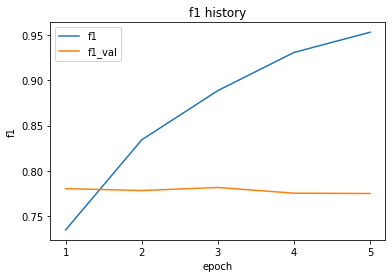

In [ ]:
fig, ax = plt.subplots()
ax.set_title("f1 history")
ax.set_ylabel("f1")
ax.set_xlabel("epoch")
plt.xticks(ticks=np.arange(0,20), labels=np.arange(1,21))
history_df.loc[:,['f1', 'f1_val']].plot(ax=ax)
plt.show()

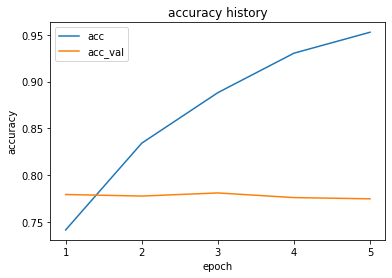

In [ ]:
fig, ax = plt.subplots()
ax.set_title("accuracy history")
ax.set_ylabel("accuracy")
ax.set_xlabel("epoch")
plt.xticks(ticks=np.arange(0,20), labels=np.arange(1,21))
history_df.loc[:,['acc', 'acc_val']].plot(ax=ax)
plt.show()

## Evaluate model
We load our best model on the validation set based on the f1-score, and evaluate it on the test set.

In [ ]:
model = torch.load("../models/bert_clf_sentiment_analysis.pt")

In [ ]:
preds_np = np.array([])
y_np = np.array([])
acc_test_total = 0
f1_test_total = 0
for batch in test_dataloader:
    x_batch, y_batch = [batch[0].to(device), batch[1].to(device)]
    with torch.no_grad(): # gradients don't have to be computed, because no update is performed
        probas = (model(tokens=x_batch))
    preds_batch_np = np.argmax(probas.cpu().detach().numpy(), axis=1)
    preds_np = np.concatenate((preds_np, preds_batch_np))
    y_batch_np = np.argmax(y_batch.cpu().detach().numpy(), axis=1)
    y_np = np.concatenate((y_np, y_batch_np))
    acc_f1_test_batch = eval(y_batch, probas)
    acc_test_total, f1_test_total = acc_test_total + acc_f1_test_batch[0], f1_test_total + acc_f1_test_batch[1]
acc_test_total = acc_test_total/len(test_dataloader)
f1_test_total = f1_test_total/len(test_dataloader)
print("Test accuracy: ", acc_test_total, "\nTest f1: ", f1_test_total, "\n")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()


Test accuracy:  0.7875298151460942 
Test f1:  0.7879475697701487 



### Confusion matrix


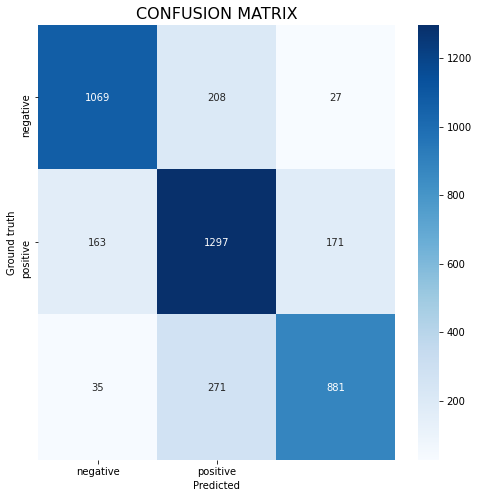

In [ ]:
conf_mat = confusion_matrix(y_np, preds_np)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=['negative', 'positive'], 
            yticklabels=['negative', 'positive'])
plt.ylabel('Ground truth')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX", size=16);

#### *Observation:*
The prediction errors from the model are fairly balanced. but when we tried to fix it it overall made the performance slightly worst. However with an f1 score and an accuracy over 0.79, the model is performing pretty well. It is much better than what we could get from the SM spaCy model which provided an f1-score of 0.67. (See notebook in this [repository](https://github.com/jfolleas1/nlp.text-classification.spacy).)